# cnn implementation on CIFAR 10


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_data = torchvision.datasets.CIFAR10(
    root = 'data',
    train = True,
    transform=ToTensor(),
    download= True
)

test_data = torchvision.datasets.CIFAR10(
    root = 'data',
    train = False,
    transform=ToTensor(),
    download= True
)

100%|██████████| 170M/170M [00:05<00:00, 31.5MB/s]


In [4]:
image, label = train_data[1]

In [5]:

image, label

(tensor([[[0.6039, 0.4941, 0.4118,  ..., 0.3569, 0.3412, 0.3098],
          [0.5490, 0.5686, 0.4902,  ..., 0.3765, 0.3020, 0.2784],
          [0.5490, 0.5451, 0.4510,  ..., 0.3098, 0.2667, 0.2627],
          ...,
          [0.6863, 0.6118, 0.6039,  ..., 0.1647, 0.2392, 0.3647],
          [0.6471, 0.6118, 0.6235,  ..., 0.4039, 0.4824, 0.5137],
          [0.6392, 0.6196, 0.6392,  ..., 0.5608, 0.5608, 0.5608]],
 
         [[0.6941, 0.5373, 0.4078,  ..., 0.3725, 0.3529, 0.3176],
          [0.6275, 0.6000, 0.4902,  ..., 0.3882, 0.3137, 0.2863],
          [0.6078, 0.5725, 0.4510,  ..., 0.3216, 0.2745, 0.2706],
          ...,
          [0.6549, 0.6039, 0.6275,  ..., 0.1333, 0.2078, 0.3255],
          [0.6039, 0.5961, 0.6314,  ..., 0.3647, 0.4471, 0.4745],
          [0.5804, 0.5804, 0.6118,  ..., 0.5216, 0.5255, 0.5216]],
 
         [[0.7333, 0.5333, 0.3725,  ..., 0.2784, 0.2784, 0.2745],
          [0.6627, 0.6039, 0.4627,  ..., 0.3059, 0.2431, 0.2392],
          [0.6431, 0.5843, 0.4392,  ...,

Image shape: torch.Size([3, 32, 32])


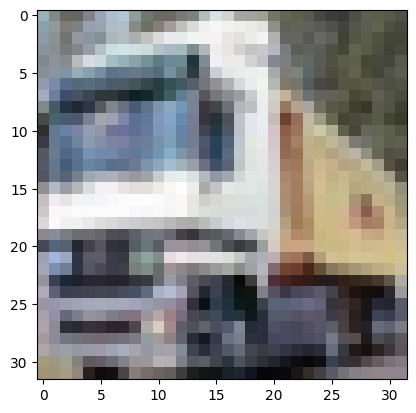

In [6]:
print(f"Image shape: {image.shape}")
image = image.permute(1, 2, 0)  # Now it's (32, 32, 3)

# Plot the image
plt.imshow(image)
plt.show()

In [7]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

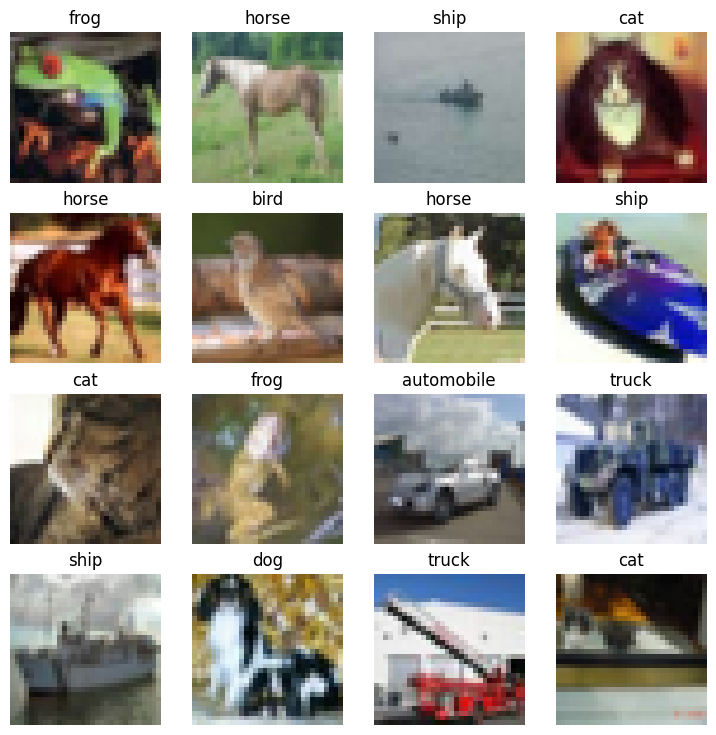

In [8]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    img = img.permute(1,2,0)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis(False);

In [9]:
batch_size = 8

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle = False
)
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7adae1b33c10>, <torch.utils.data.dataloader.DataLoader object at 0x7adaece695d0>)
Length of train dataloader: 6250 batches of 8
Length of test dataloader: 1250 batches of 8


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([8, 3, 32, 32]), torch.Size([8]))

In [11]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([3, 32, 32]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 1024]) -> [color_channels, height*width]


> input_layer -> [convulational layer -> activation layer -> pooling layer] -> output_layer

In [31]:
class CIFAR10CNN(nn.Module):

  def __init__(self):
      super().__init__()
      self.block1 = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
          nn.BatchNorm2d(32),  # Add batch normalization
          nn.ReLU(),
          nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.block2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Dropout(0.5),  # Add dropout for regularization
          nn.Linear(in_features=64*8*8, out_features=10)
      )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.classifier(x)
    return x

In [32]:
model = CIFAR10CNN()
model

CIFAR10CNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
model.to(device)

CIFAR10CNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(

In [36]:
import sklearn

In [39]:
import torch
import torch.nn as nn
from tqdm import tqdm

# Define loss function and optimizer with proper learning rate
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)  # Reduced learning rate

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# Training loop with validation
epochs = 15
best_val_acc = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss, train_acc = 0, 0

    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for batch, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)

            # Forward pass
            y_pred = model(x)
            loss = loss_fn(y_pred, y.long())

            # Calculate metrics
            train_loss += loss.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            pbar.set_postfix({
                "loss": f"{train_loss / (batch+1):.5f}",
                "acc": f"{train_acc / ((batch+1) * x.size(0)):.4f}"
            })

    # Calculate average training metrics
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)

    # Print epoch results
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.4f}")


Epoch 1/15: 100%|██████████| 6250/6250 [00:42<00:00, 148.55it/s, loss=0.51659, acc=0.8183]


Epoch 1/15 | Train loss: 0.51659 | Train accuracy: 0.8183


Epoch 2/15: 100%|██████████| 6250/6250 [00:41<00:00, 150.24it/s, loss=0.51012, acc=0.8222]


Epoch 2/15 | Train loss: 0.51012 | Train accuracy: 0.8222


Epoch 3/15: 100%|██████████| 6250/6250 [00:41<00:00, 149.86it/s, loss=0.50820, acc=0.8235]


Epoch 3/15 | Train loss: 0.50820 | Train accuracy: 0.8235


Epoch 4/15: 100%|██████████| 6250/6250 [00:41<00:00, 151.28it/s, loss=0.49668, acc=0.8274]


Epoch 4/15 | Train loss: 0.49668 | Train accuracy: 0.8274


Epoch 5/15: 100%|██████████| 6250/6250 [00:41<00:00, 151.91it/s, loss=0.50006, acc=0.8247]


Epoch 5/15 | Train loss: 0.50006 | Train accuracy: 0.8247


Epoch 6/15: 100%|██████████| 6250/6250 [00:41<00:00, 150.22it/s, loss=0.49059, acc=0.8301]


Epoch 6/15 | Train loss: 0.49059 | Train accuracy: 0.8301


Epoch 7/15: 100%|██████████| 6250/6250 [00:41<00:00, 150.38it/s, loss=0.48502, acc=0.8302]


Epoch 7/15 | Train loss: 0.48502 | Train accuracy: 0.8302


Epoch 8/15: 100%|██████████| 6250/6250 [00:41<00:00, 150.56it/s, loss=0.47991, acc=0.8308]


Epoch 8/15 | Train loss: 0.47991 | Train accuracy: 0.8308


Epoch 9/15: 100%|██████████| 6250/6250 [00:41<00:00, 150.83it/s, loss=0.48280, acc=0.8319]


Epoch 9/15 | Train loss: 0.48280 | Train accuracy: 0.8319


Epoch 10/15: 100%|██████████| 6250/6250 [00:41<00:00, 152.35it/s, loss=0.46946, acc=0.8349]


Epoch 10/15 | Train loss: 0.46946 | Train accuracy: 0.8349


Epoch 11/15: 100%|██████████| 6250/6250 [00:40<00:00, 152.84it/s, loss=0.46782, acc=0.8358]


Epoch 11/15 | Train loss: 0.46782 | Train accuracy: 0.8358


Epoch 12/15: 100%|██████████| 6250/6250 [00:41<00:00, 151.01it/s, loss=0.46830, acc=0.8362]


Epoch 12/15 | Train loss: 0.46830 | Train accuracy: 0.8362


Epoch 13/15: 100%|██████████| 6250/6250 [00:41<00:00, 149.02it/s, loss=0.46526, acc=0.8377]


Epoch 13/15 | Train loss: 0.46526 | Train accuracy: 0.8377


Epoch 14/15: 100%|██████████| 6250/6250 [00:41<00:00, 152.30it/s, loss=0.46065, acc=0.8395]


Epoch 14/15 | Train loss: 0.46065 | Train accuracy: 0.8395


Epoch 15/15: 100%|██████████| 6250/6250 [00:41<00:00, 151.66it/s, loss=0.45739, acc=0.8401]

Epoch 15/15 | Train loss: 0.45739 | Train accuracy: 0.8401


In [40]:
from tqdm import tqdm
import torch

def evaluate_model(model, test_dataloader, loss_fn, device):
    """
    Evaluate the model on test data and return loss and accuracy
    """
    loss, acc = 0, 0
    model.eval()
    num_samples = 0

    with torch.inference_mode():
        with tqdm(test_dataloader, desc="Evaluating") as pbar:
            for batch_idx, (X, y) in enumerate(pbar):
                # Move data to device
                X, y = X.to(device), y.to(device)

                # Make predictions with the model
                y_pred = model(X)

                # Calculate batch loss
                batch_loss = loss_fn(y_pred, y)
                loss += batch_loss.item()

                # Calculate batch accuracy
                batch_correct = (y_pred.argmax(dim=1) == y).sum().item()
                acc += batch_correct
                num_samples += X.size(0)

                # Update the progress bar with the current metrics
                pbar.set_postfix({
                    "loss": f"{loss / (batch_idx + 1):.5f}",
                    "acc": f"{(acc / num_samples) * 100:.2f}%"
                })

    # Calculate final metrics
    avg_loss = loss / len(test_dataloader)
    avg_acc = acc / len(test_dataloader.dataset)

    # Print the final results
    print(f"Evaluation Results | Loss: {avg_loss:.5f} | Accuracy: {(avg_acc * 100):.2f}%")

    return avg_loss, avg_acc

# Usage
test_loss, test_acc = evaluate_model(model, test_dataloader, loss_fn, device)

Evaluating: 100%|██████████| 1250/1250 [00:05<00:00, 229.92it/s, loss=0.59873, acc=79.72%]

Evaluation Results | Loss: 0.59873 | Accuracy: 79.72%
